In [44]:
import pandas as pd
import geopy.distance
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapely.wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.prepared import prep

#### Get borders of vienna and create grid on them

In [45]:
vienna_border = pd.read_csv("data/LANDESGRENZEOGD.csv")

def create_polygon(x):
    x['Polygon'] = shapely.wkt.loads(x['SHAPE'])
    return x

vienna_border = vienna_border.apply(lambda x: create_polygon(x), axis=1)
vienna_border.drop("SHAPE", inplace=True, axis=1)
vienna_border.head()

,FID,OBJECTID,NAME_LANDK,NAME_LANDG,NAME_GEMK,NAME_GEMG,STATAUSTRIA_LAND_KENN,STATAUSTRIA_GEM_KENN,STATAUSTRIA_BEZ_KENN,STATAUSTRIA_BEZ_CODE,FLAECHE,UMFANG,LU_DATE,SE_ANNO_CAD_DATA,Polygon
0,LANDESGRENZEOGD.10881,10881,Wien,WIEN,Stadt Wien,STADT WIEN,9,90001,900,900,4.148711e+08,136475.45,2022-08-26,NaN,POLYGON ((16.437761721115034 48.31681098205513...


In [46]:
# stolen from https://www.matecdev.com/posts/shapely-polygon-gridding.html
def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx)/delta)
    ny = int((maxy - miny)/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            grid.append( poly_ij )
    return grid
def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid

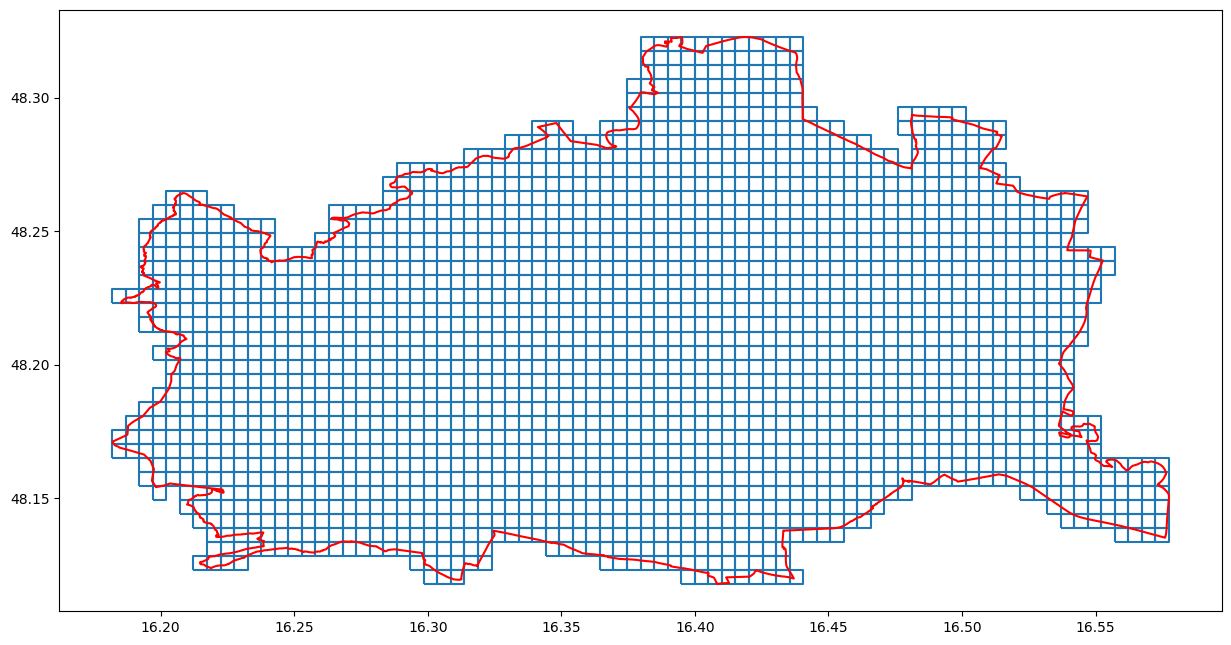

In [47]:
geom = vienna_border.Polygon[0]
grid = partition(geom, 0.005)

fig, ax = plt.subplots(figsize=(15, 15))
gpd.GeoSeries(grid).boundary.plot(ax=ax)
gpd.GeoSeries([geom]).boundary.plot(ax=ax,color="red")
plt.show()

#### Check whether data points are in grid

In [48]:
listings = pd.read_csv("data/listings.csv")
listings_cleaned = listings[["id", "name", "neighbourhood_cleansed", "latitude", "longitude", "property_type",
                             "room_type", "accommodates", "bedrooms", "price","number_of_reviews",
                             "review_scores_rating", "review_scores_location", "reviews_per_month"]]
listings_cleaned = listings_cleaned.dropna()

In [50]:
def create_point(x, from_shape=True, column1 = None, column2 = None):
    if from_shape:
        x['Point'] = shapely.wkt.loads(x['SHAPE'])
    else:
        x['Point'] = Point(x[column1], x[column2])
    return x

listings_cleaned = listings_cleaned.apply(lambda x: create_point(x, from_shape=False, column1='longitude', column2='latitude'), axis=1)

In [51]:
def inside_square(x, grid):
    point = x['Point']
    for sq_id, square in enumerate(grid):
        if square.contains(point):
            x['grid_id'] = sq_id
    return x

grid_listings = listings_cleaned.apply(lambda x: inside_square(x, grid), axis=1)

In [52]:
grid_listings.head()

,Point,accommodates,bedrooms,grid_id,id,latitude,longitude,name,neighbourhood_cleansed,number_of_reviews,price,property_type,review_scores_location,review_scores_rating,reviews_per_month,room_type
0,POINT (16.42767 48.24262),3,1.0,1364.0,15883,48.24262,16.42767,b&b near Old Danube river,Donaustadt,14,$110.00,Room in bed and breakfast,4.71,4.71,0.15,Hotel room
1,POINT (16.37831 48.21924),5,1.0,976.0,38768,48.21924,16.37831,central cityapartement- wifi- nice neighbourhood,Leopoldstadt,350,$69.00,Entire rental unit,4.75,4.75,2.50,Entire home/apt
2,POINT (16.32701 48.18434),6,2.0,665.0,40625,48.18434,16.32701,"Near Palace Schönbrunn, Apt. 1",Rudolfsheim-Fnfhaus,181,$145.00,Entire rental unit,4.59,4.83,1.23,Entire home/apt
3,POINT (16.37161 48.21496),2,1.0,943.0,392757,48.21496,16.37161,VCA3 Palais Brambilla - studio with city views,Innere Stadt,100,$100.00,Entire rental unit,4.89,4.64,0.79,Entire home/apt
5,POINT (16.37282 48.21351),2,1.0,943.0,392905,48.21351,16.37282,City Apartment 1- Palais Brambilla romantic style,Innere Stadt,52,$99.00,Entire rental unit,4.88,4.63,0.43,Entire home/apt


In [53]:
stations = pd.read_csv("data/HALTESTELLEWLOGD.csv")
stations = stations.apply(lambda x: create_point(x), axis=1)
stations.drop("SHAPE", inplace=True, axis=1)

In [55]:
grid_stations = stations.apply(lambda x: inside_square(x, grid), axis=1)

In [57]:
grid_stations.head()

,BEZEICHNUNG,FID,OBJECTID,Point,SE_ANNO_CAD_DATA,WL_NUMMER,grid_id
0,Absberggasse,HALTESTELLEWLOGD.1,1,POINT (16.389770011932953 48.17379006621729),NaN,1,1040.0
1,Achengasse,HALTESTELLEWLOGD.2,2,POINT (16.448900012566884 48.2845300657776),NaN,2,1515.0
2,Ada-Christen-Gasse,HALTESTELLEWLOGD.3,3,POINT (16.38581001194899 48.15293006544885),NaN,3,1036.0
3,Adam-Betz-Gasse,HALTESTELLEWLOGD.4,4,POINT (16.535120013111975 48.21564006599573),NaN,4,1944.0
4,Adamovichgasse,HALTESTELLEWLOGD.5,5,POINT (16.337990012520667 48.142290065576454),NaN,5,714.0


,BEZEICHNUNG,FID,OBJECTID,Point,SE_ANNO_CAD_DATA,WL_NUMMER,grid_id
0,Absberggasse,HALTESTELLEWLOGD.1,1,POINT (16.389770011932953 48.17379006621729),NaN,1,1040.0
1,Achengasse,HALTESTELLEWLOGD.2,2,POINT (16.448900012566884 48.2845300657776),NaN,2,1515.0
2,Ada-Christen-Gasse,HALTESTELLEWLOGD.3,3,POINT (16.38581001194899 48.15293006544885),NaN,3,1036.0
3,Adam-Betz-Gasse,HALTESTELLEWLOGD.4,4,POINT (16.535120013111975 48.21564006599573),NaN,4,1944.0
4,Adamovichgasse,HALTESTELLEWLOGD.5,5,POINT (16.337990012520667 48.142290065576454),NaN,5,714.0


In [58]:
tourism = pd.read_csv("data/WIENTOURISMUSOGD.csv")
toursim_cleaned = tourism[['NAME','POSTALCODE', 'CATEGORY_NAME','SUBCATEGORY_NAME', 'GEOLAT', 'GEOLONG']]
remove_cats = ['Hotel', 'Pension', 'Appartement', 'Saisonhotel']
toursim_cleaned = toursim_cleaned[~toursim_cleaned['SUBCATEGORY_NAME'].isin(remove_cats)]
toursim_cleaned.head()

,NAME,POSTALCODE,CATEGORY_NAME,SUBCATEGORY_NAME,GEOLAT,GEOLONG
0,Porzellan,1090,"Essen, Trinken & Nightlife",Restaurant,48.219222,16.364447
1,Postamt 1150 Wien,1150,Infrastruktur,Sonstiges,48.195808,16.338125
2,Prater Alm,1020,"Essen, Trinken & Nightlife",Gasthaus & Beisl,48.215450,16.402072
3,Pratermuseum,1020,Sightseeing,Museum,48.216236,16.394952
4,Praterturm,1020,Sightseeing,Sehenswürdigkeit,48.216727,16.398029


In [59]:
toursim_cleaned = toursim_cleaned.apply(lambda x: create_point(x, from_shape=False, column1='GEOLONG', column2='GEOLAT'))
toursim_cleaned.head()

KeyError: 'GEOLONG'